### Helpers

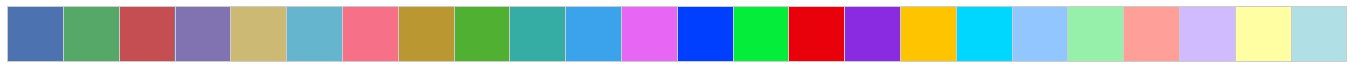

In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import utils
import scoring

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [9]:
def get_simple_features(data):
    return data.loc[:, FEATURES_COLS]

x_cols = ['MatchedHit_X[%i]' % i for i in range(utils.N_STATIONS)]
y_cols = ['MatchedHit_Y[%i]' % i for i in range(utils.N_STATIONS)]
z_cols = ['MatchedHit_Z[%i]' % i for i in range(utils.N_STATIONS)]

da_cols = ['MatchedHit_DA[%d]' % i for i in range(1, 4)]
da_cols = ['MatchedHit_DA[%d]' % i for i in range(1, 4)]

FEATURES_COLS = [
#     'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
    'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]',
    'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 
    'MatchedHit_Z[0]', 'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
#     'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]',
#     'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]',
#     'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
#     'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]',
#     'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]',
#     'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]',
#     'Lextra_Y[0]', 'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]',
#     'Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]',
#     'Mextra_DY2[0]', 'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]',
#     'FOI_hits_N', 'PT', 'P'
]

TRAINSET_COLS = [utils.ID_COLUMN] + FEATURES_COLS + utils.TRAIN_COLUMNS
TESTSET_COLS = [utils.ID_COLUMN] + FEATURES_COLS

In [17]:
%%time
train_00 = pd.read_csv('data/train_part_1_v2.csv.gz', nrows=200000, na_values='-9999.0', usecols=TRAINSET_COLS, index_col=utils.ID_COLUMN)
train_01 = pd.read_csv('data/train_part_2_v2.csv.gz', nrows=200000, na_values='-9999.0', usecols=TRAINSET_COLS, index_col=utils.ID_COLUMN)
train_0 = pd.concat([train_00, train_01], axis=0, ignore_index=False)

# test_0 = pd.read_csv('data/test_public_v2.csv.gz', na_values='-9999.0', usecols=TESTSET_COLS, index_col=utils.ID_COLUMN)

print(train_0.shape, test_0.shape)

(400000, 14) (726095, 12)
Wall time: 8.46 s


In [18]:
train = train_0
test = test_0

### Pipeline

In [12]:
def get_class(i):
    return train.index[train.label == i]

# Gets `n_rows` random samples from `data`
def get_samples(data, n_rows):
    indices = np.random.randint(len(data), size=n_rows)
    indices = np.sort(indices)
    return data.iloc[indices]

# Gets `n_rows` random samples from `data` with specified class proportions.
# If `prop_0` is None, it keeps `data`s natural proportions.
def get_samples_w_proptions(data, n_rows, prop_0=None):
    def get_class_samples(class_i, n_rows):
        class_indices = np.random.randint(len(class_i), size=n_rows)
        return class_i[class_indices]
    
    if prop_0 is None:
        prop_0 = len(class_0) / (len(class_0) + len(class_1))
    cnt_0 = int(n_rows * prop_0)
    class_0_indices = get_class_samples(class_0, cnt_0)
    class_1_indices = get_class_samples(class_1, n_rows - cnt_0)
    indices = np.concatenate((class_0_indices, class_1_indices))
    indices = np.sort(indices)
    return data.loc[indices]

# Gets `n_rows` head samples from `data` with specified class proportions.
# If `prop_0` is None, it keeps `data`s natural proportions.
# If `data` samples is not enough to fulfil proportions for any `class_i` then random sampling from the `class_i` is applied.
def get_head_w_proportions(data, n_rows, prop_0=None):
    def get_class_samples_head_smart(class_i, n_rows):
        cls_len = len(class_i)
        if cls_len > n_rows:
            return class_i[:n_rows]
        class_indices = np.concatenate((np.arange(cls_len),  np.random.randint(cls_len, size=n_rows-cls_len)))
        return class_i[class_indices]
    
    if prop_0 is None:
        prop_0 = len(class_0) / (len(class_0) + len(class_1))
    cnt_0 = int(n_rows * prop_0)
    class_0_indices = get_class_samples_head_smart(class_0, cnt_0)
    class_1_indices = get_class_samples_head_smart(class_1, n_rows - cnt_0)
    indices = np.concatenate((class_0_indices, class_1_indices))
    indices = np.sort(indices)
    return data.loc[indices]
    
print(np.count_nonzero(train.label == 0), np.count_nonzero(train.label == 1))

class_0 = get_class(0)
class_1 = get_class(1)

30588 369412


In [22]:
import xgboost as xgb
from sklearn import model_selection as mdsel

def fit(train):
    target_train = train.loc[:, utils.TRAIN_COLUMNS]
    
    # defined much later
    transformer = DataTransformer().fit(train)
    train = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=150, n_jobs=3)
    estimator.fit(train.values, target_train.label.values, sample_weight=target_train.weight.values, eval_metric=scoring.rejection90_sklearn)
    return transformer, estimator
    
def predict(fitted_state, test):
    transformer, estimator = fitted_state
    
    test = transformer.transform(test)
    predictions = estimator.predict_proba(test.values)[:, 1]
    return predictions

def score(fitted_state, test):
    target_test = test.loc[:, utils.TRAIN_COLUMNS]
    predictions = predict(fitted_state, test)
    score = scoring.rejection90(target_test.label.values, predictions, sample_weight=target_test.weight.values)
    return score

def fit_predict_save(train, test, filename):
    fitted_state = fit(train)
    predictions = predict(fitted_state, test)
    
    pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
        filename, index_label=utils.ID_COLUMN
    )
    
def cross_validate(train, n_splits, n_rows=1000):
    # сделать честную случайную подвыборку
    train = get_head_w_proportions(train, n_rows, .5)
    
    splitter = mdsel.StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = []
    for train_indices, test_indices in splitter.split(train, train.label):
        train_subset = train.iloc[train_indices]
        test_subset = train.iloc[test_indices]
        
        fit_state = fit(train_subset)
        scores += [score(fit_state, test_subset)]

    return pd.DataFrame(scores, columns=['Score'])

### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

##### PCA

In [14]:
from sklearn.decomposition import PCA

def fill_na(data):
    mask = data.isna()
    means = data.mean(skipna=True)
    data.fillna(means, inplace=True)
    return mask

def restore_na(data, mask):
    data.mask(mask, other=np.NaN, inplace=True)
    
def get_nth_detector_coords(i):
    return [x_cols[i], y_cols[i], z_cols[i]]
    
def fit_pca(data):
    cols = get_nth_detector_coords(0)
    data = data.loc[:, cols].copy()
    
    fill_na(data)
    pca_model = PCA(n_components=3)
    pca_model.fit(data)
    return pca_model

def transform_pca(pca_model, data):
    for i in range(4):
        cols = get_nth_detector_coords(i)
        data_detector = data.loc[:, cols]
        
        mask = fill_na(data_detector)
        data_detector.update(pca_model.transform(data_detector.values))
        restore_na(data_detector, mask)
    return data

##### Cosine dist

In [15]:
def add_coses(data):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values

    def dot(x, y):
        return np.sum(x * y, axis=1)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        return dot(L1, L2) / L1_norm / L2_norm
    
    def get_angle(cosines):
        return np.arccos(cosines, dtype=np.float32) / np.pi * 180
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    norms = list(map(norm, layers))
    
    for i in range(3):
        cosines = get_cosine_dist(layers[i], layers[i+1], norms[i], norms[i+1])
        angles = get_angle(cosines)
        data[da_cols[i]] = angles
        
    return data

In [16]:
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers

    def fit(self, data, y=None):
        self.pca_model = fit_pca(data)
        return self

    def transform(self, data):
        data = get_simple_features(data)
        
        transform_pca(self.pca_model, data)
        add_coses(data)
        return data

### Test theory

In [21]:
%%time
df_scores = cross_validate(train, n_splits=5, n_rows=100000)
print(df_scores.describe())

          Score
count  5.000000
mean   0.630520
std    0.028313
min    0.605589
25%    0.615881
50%    0.622852
75%    0.629685
max    0.678594
Wall time: 33.9 s


### Get result

In [ ]:
%%time
fit_predict_save(get_head_w_proportions(train, 100000), test, "out/05_no_props_4m_4m.csv")

In [564]:
%%time
fit_predict_save(get_samples_w_proptions(train, 100000, .8), test, "out/04_prop_80_20_100_800.csv")

Wall time: 9.55 s


In [539]:
%%time
fit_predict_save(train.iloc[:100000], test, "out/03_baseline_head_100.csv")

Wall time: 8.72 s


### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])